In [1362]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('once')


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

plt.style.use('ggplot')

In [1364]:
train_df = pd.read_csv('../KaggleHomePrice/train.csv')
submission_df = pd.read_csv('../KaggleHomePrice/test.csv')

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1366]:
#there are some outliers in the saleprice as expected
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: xlabel='SalePrice', ylabel='Count'>

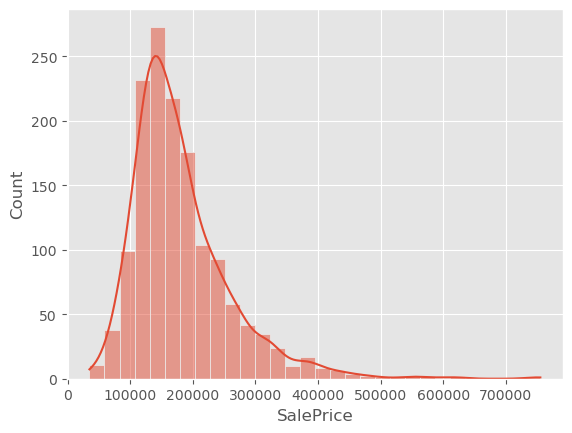

In [1368]:
#checking if the saleprice is heavily skewed
sns.histplot(train_df['SalePrice'], bins=30, kde=True)

<Axes: xlabel='LogSalePrice', ylabel='Count'>

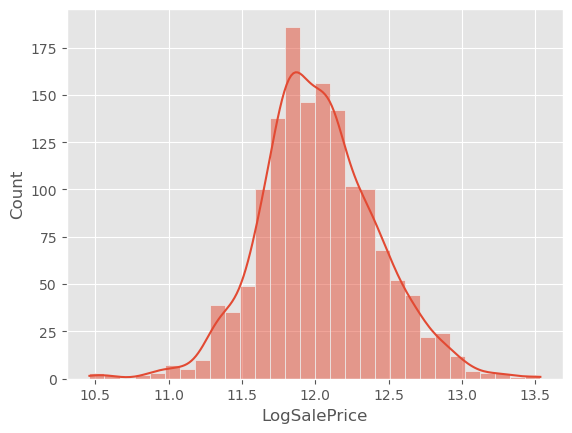

In [1369]:
#better
train_df['LogSalePrice'] = np.log(train_df['SalePrice'])
sns.histplot(train_df['LogSalePrice'], bins=30, kde=True)

We have a lot of features that overlap in this dataset, since our goal is to apply some form of regression, it is paramount to decrease the featureset to avoid multicollinearity

<Axes: >

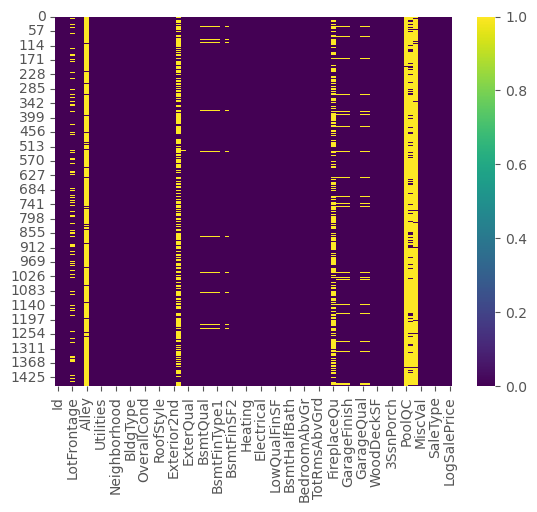

In [1372]:
sns.heatmap(train_df.isnull(), cmap='viridis')

In [1374]:
train_df['WoodDeckSF'].describe()

count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

In [1375]:
train_df.query('WoodDeckSF == 0')['SalePrice'].mean(), train_df.query('WoodDeckSF != 0')['SalePrice'].mean() # wooddecks matter

(158265.69513797635, 205586.1974248927)

<Axes: xlabel='SalePrice', ylabel='Count'>

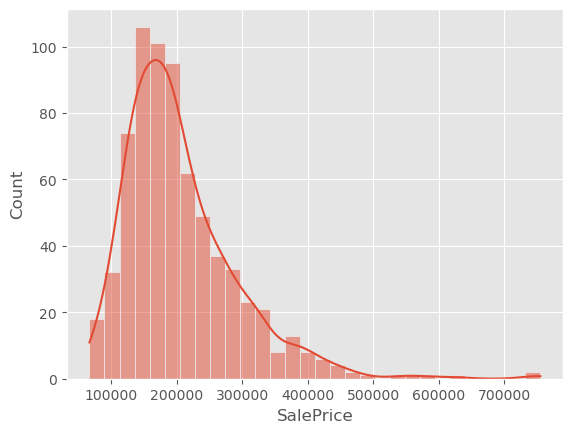

In [1377]:
train_df.query('WoodDeckSF != 0')['WoodDeckSF'].mean()
train_df.query('WoodDeckSF > 150')['SalePrice'].mean(), train_df.query('WoodDeckSF <= 150')['SalePrice'].mean() # big wooddecks really matter
# feature engineer wooddeck > 150 vs < 150

sns.histplot(train_df.query('WoodDeckSF != 0')['SalePrice'], bins=30, kde=True)

WoodDeckSF has a lot of zeroes

MSSubClass 60 making a big appearance in expensive homes, NoRidge neighborhood, brkface/stone maybe that would mean its a custom home




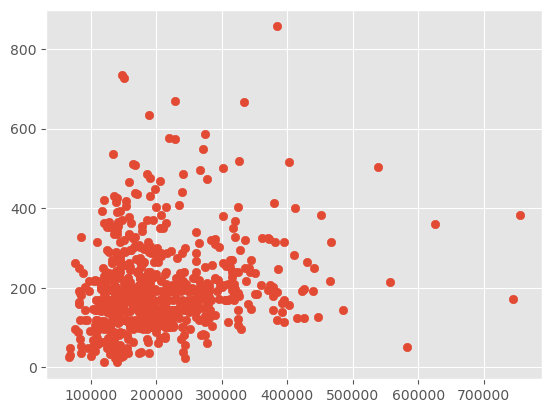

In [1382]:
data_point = 'WoodDeckSF'

plt.scatter(train_df.query('WoodDeckSF > 0')['SalePrice'], train_df.query('WoodDeckSF > 0')['{}'.format(data_point)])

In [1383]:
train_df.query('SalePrice > 600000')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,LogSalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000,13.534473
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,0,142,2330,GasA,Ex,Y,SBrkr,2364,0,0,2364,1,0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657,13.323927
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000,13.345507
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,NaN,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000,13.521139


<Axes: >

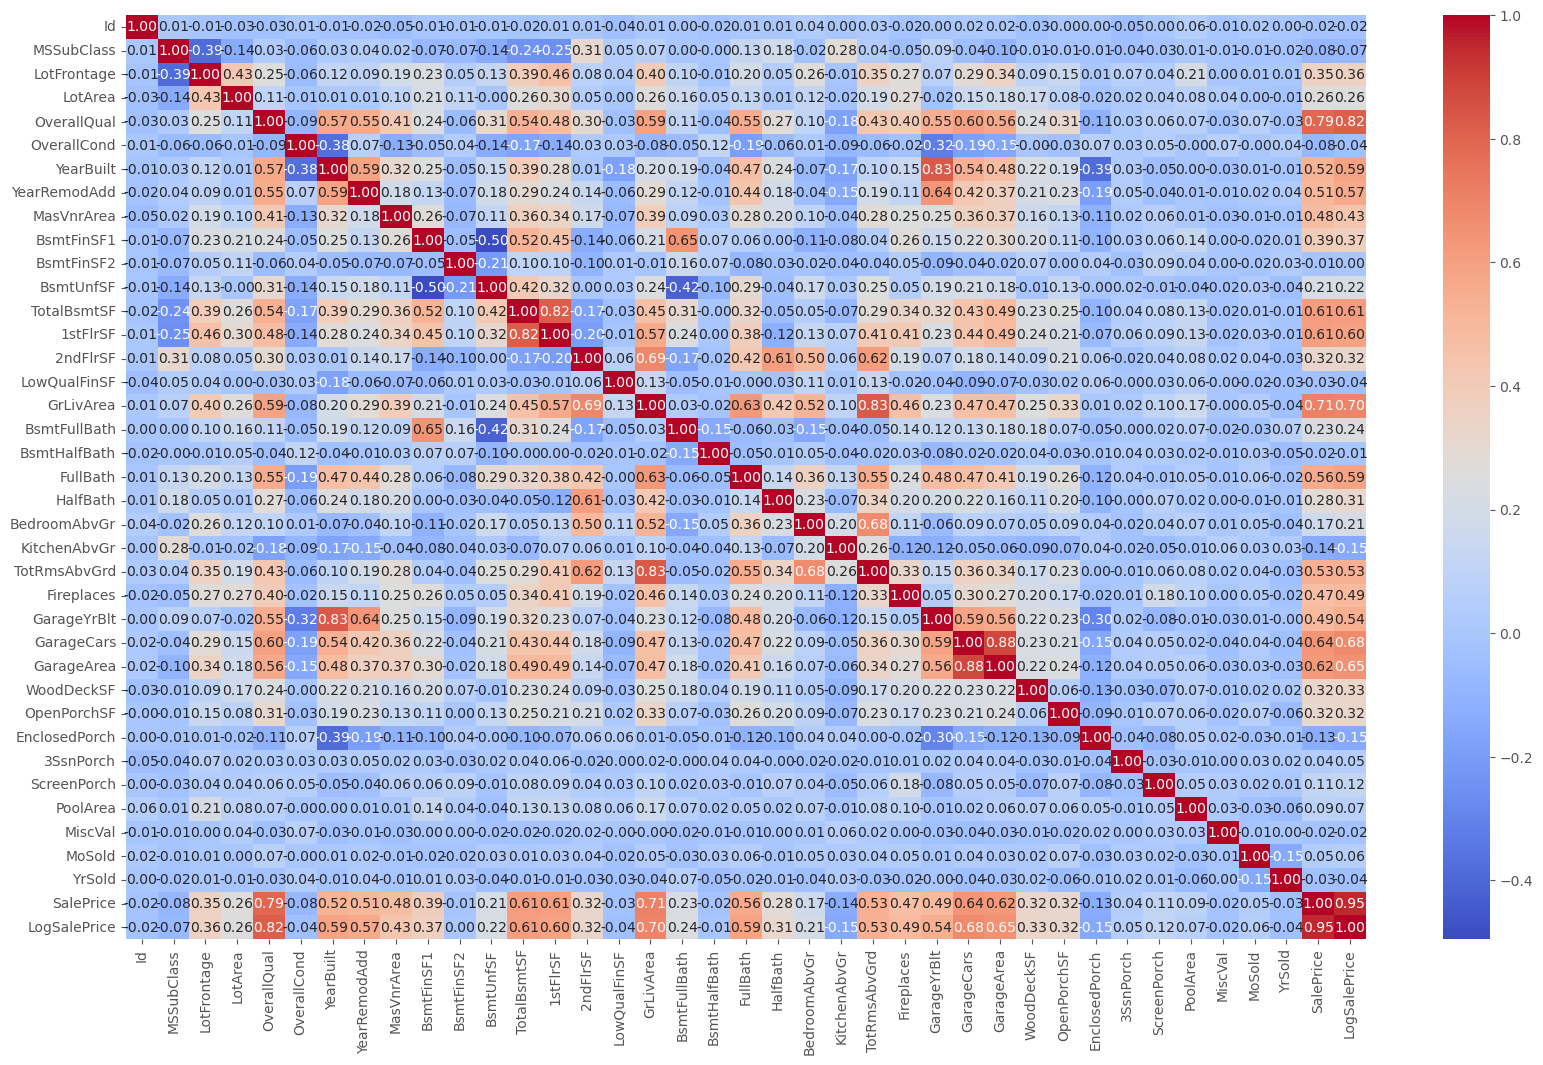

In [1384]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

noticing that the mssubclass column is heavily correlated to other features as it is just a summary of the build style

In [1388]:
train_df.select_dtypes(include='object').columns.tolist, train_df.select_dtypes(include=['float64', 'int64']).columns.tolist

(<bound method IndexOpsMixin.tolist of Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object')>,
 <bound method IndexOpsMixin.tolist of Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 

In [1389]:
len(train_df.columns)

82

What are we gonna do:

WoodDeckSF

LogSalePrice

TotalSF

TotalBsmtSF

Age

Pool Y/N

TotalBedrooms

Create Overall Quality Score 1 - 5

Neighborhood Score 1 - 5

MSSubClass Drop/Reduce

In [1391]:
condition_columns = train_df.columns[train_df.columns.str.contains('cond', case=False)]
train_df[condition_columns].head()

,Condition1,Condition2,OverallCond,ExterCond,BsmtCond,GarageCond,SaleCondition
0,Norm,Norm,5,TA,TA,TA,Normal
1,Feedr,Norm,8,TA,TA,TA,Normal
2,Norm,Norm,5,TA,TA,TA,Normal
3,Norm,Norm,5,TA,Gd,TA,Abnorml
4,Norm,Norm,5,TA,TA,TA,Normal


In [1392]:
condition_score = {
    'Artery': -1,
    'Feedr': -1,
    'Norm': 0,
    'RRNn': -1,
    'RRAn': -1,
    'PosN': 1,
    'PosA': 1,
    'RRNe': -1,
    'RRAe': -1
}

def calculate_condition(row):
    score1 = condition_score.get(row['Condition1'], 0)
    score2 = condition_score.get(row['Condition2'], 0)

    return score1 + score2

train_df['Condition'] = train_df.apply(calculate_condition, axis=1)

In [1393]:
train_df = train_df.drop(columns=['Condition1', 'Condition2'])

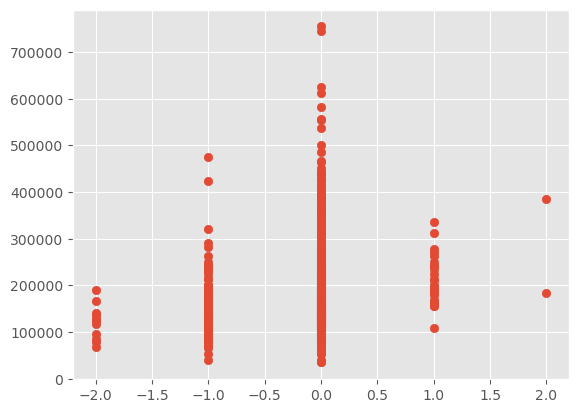

In [1394]:
plt.scatter(train_df['Condition'], train_df['SalePrice'])

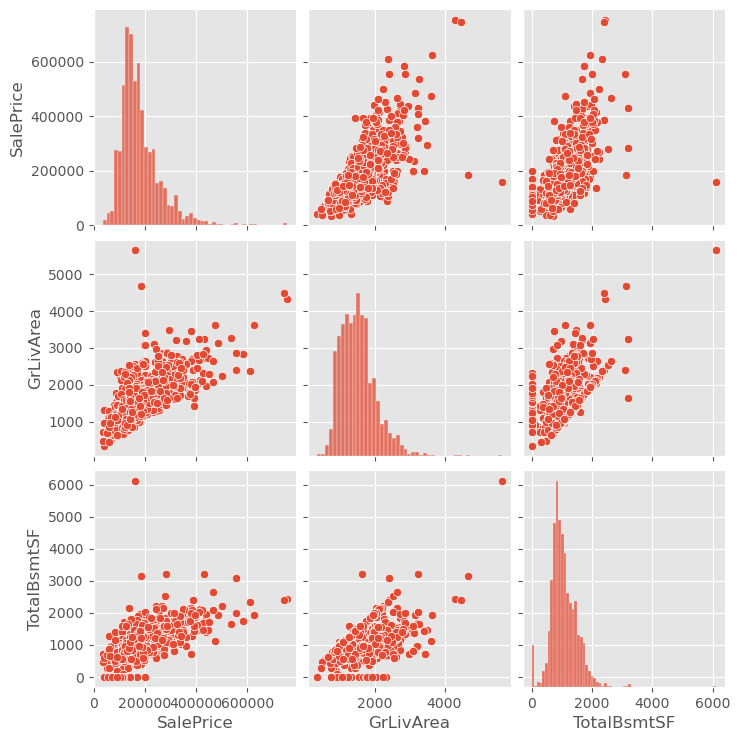

In [1395]:
sns.pairplot(train_df[['SalePrice', 'GrLivArea', 'TotalBsmtSF']]);

In [1396]:
quality_columns = train_df.columns[train_df.columns.str.contains('qual', case=False)]
train_df[quality_columns].head()

,OverallQual,ExterQual,BsmtQual,LowQualFinSF,KitchenQual,GarageQual
0,7,Gd,Gd,0,Gd,TA
1,6,TA,Gd,0,TA,TA
2,7,Gd,Gd,0,Gd,TA
3,7,TA,TA,0,Gd,TA
4,8,Gd,Gd,0,Gd,TA


In [1397]:
train_df.columns[train_df.columns.str.contains('Bsmt', case=False)]

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [1398]:
train_df.columns[train_df.columns.str.contains('Bsmt', case=False)]

train_df['BsmtFinishRatio'] = (train_df['TotalBsmtSF'] - train_df['BsmtUnfSF']) / train_df['TotalBsmtSF']
train_df = train_df.drop(columns=['BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'])

In [1445]:
train_df.columns[train_df.columns.str.contains('SF', case=False)]

Index(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF',
       'OpenPorchSF'],
      dtype='object')

In [1485]:
def engineering(train_df):
    train_df.drop(columns='Id')
    #condition
    train_df['Condition'] = train_df.apply(calculate_condition, axis=1)
    train_df = train_df.drop(columns=['Condition1', 'Condition2'])
    #bsmt finish ratio
    train_df['BsmtFinishRatio'] = (train_df['TotalBsmtSF'] - train_df['BsmtUnfSF']) / train_df['TotalBsmtSF']
    train_df = train_df.drop(columns=['BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF'])
    #total bathrooms
    train_df['FullBath']  = train_df['BsmtFullBath'].fillna(0)
    train_df['BsmtFullBath']  = train_df['BsmtFullBath'].fillna(0)
    train_df['HalfBath']  = train_df['BsmtFullBath'].fillna(0)
    train_df['BsmtHalfBath']  = train_df['BsmtFullBath'].fillna(0)
    train_df['TotalBathrooms'] = train_df['BsmtFullBath'] + train_df['FullBath'] + 0.5 * train_df['HalfBath'] + 0.5 * train_df['BsmtHalfBath']
    train_df = train_df.drop(columns=['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'])
    # neighborhood score
    train_df['TotalSF'] = train_df['TotalBsmtSF'] + train_df['1stFlrSF'] + train_df['2ndFlrSF']
    neighborhood_means = train_df.groupby('Neighborhood')[['TotalSF']].mean().round(2)
    neighborhood_means['NeighborhoodScore'] = pd.qcut(neighborhood_means['TotalSF'], 5, labels=False) + 1  
    train_df = pd.merge(train_df, neighborhood_means[['NeighborhoodScore']], on='Neighborhood', how='left')
    train_df = train_df.drop(columns='Neighborhood')
    # outdoor features
    train_df = train_df.drop(columns=['PoolQC'])
    #year since remodel
    train_df['YearSinceRemodel'] = train_df['YrSold'] - train_df['YearRemodAdd']
    train_df = train_df.drop(columns='YearRemodAdd')
    train_df = train_df.drop(columns='GarageCars')
    #porch SF
    train_df['PorchSF'] = train_df['OpenPorchSF'] + train_df['EnclosedPorch'] + train_df['3SsnPorch'] + train_df['ScreenPorch']
    train_df = train_df.drop(columns=['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'])
    #datesold
    train_df['DateSold'] = train_df['YrSold'] + (train_df['MoSold'] / 12)
    train_df = train_df.drop(columns=['YrSold', 'MoSold'])
    #masvner
    train_df = train_df.drop(columns='MasVnrArea')
    return train_df

In [1401]:
len(train_df.columns.tolist())

77

In [1402]:
train_df.isna().sum()

Id                    0
MSSubClass            0
MSZoning              0
LotFrontage         259
LotArea               0
Street                0
Alley              1369
LotShape              0
LandContour           0
Utilities             0
LotConfig             0
LandSlope             0
Neighborhood          0
BldgType              0
HouseStyle            0
OverallQual           0
OverallCond           0
YearBuilt             0
YearRemodAdd          0
RoofStyle             0
RoofMatl              0
Exterior1st           0
Exterior2nd           0
MasVnrType          872
MasVnrArea            8
ExterQual             0
ExterCond             0
Foundation            0
BsmtQual             37
BsmtCond             37
BsmtExposure         38
TotalBsmtSF           0
Heating               0
HeatingQC             0
CentralAir            0
Electrical            1
1stFlrSF              0
2ndFlrSF              0
LowQualFinSF          0
GrLivArea             0
BsmtFullBath          0
BsmtHalfBath    

In [1404]:
train_df.columns[train_df.columns.str.contains('Porch', case=False)]

Index(['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], dtype='object')

<Axes: >

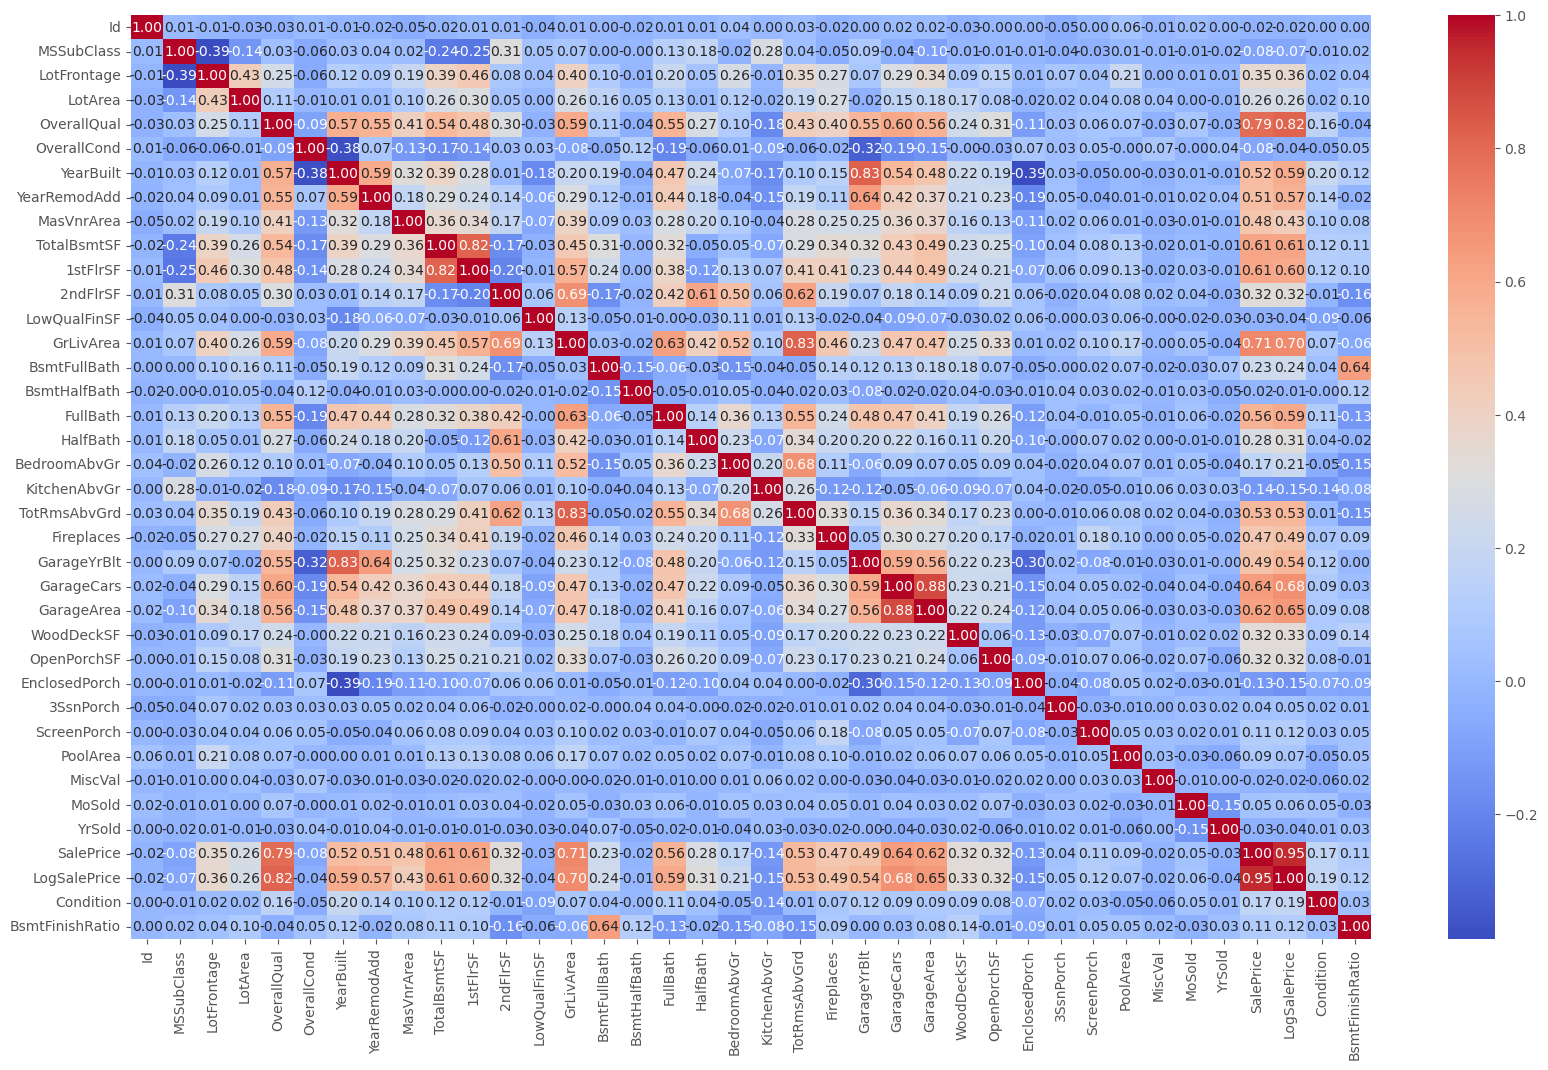

In [1411]:
correlation_matrix = train_df.corr(numeric_only=True)
plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

steps for ml pipeline:

num transformer - transform num columns
cat transformer - transform cat columns
preprocessor - applies num and cat tranformers
pipeline - preprocessor => model

In [1487]:
train_df = pd.read_csv('../KaggleHomePrice/train.csv')
submission_df = pd.read_csv('../KaggleHomePrice/test.csv')

train_df = engineering(train_df)
submission_df = engineering(submission_df)

train_df['LogSalePrice'] = np.log(train_df['SalePrice'])

In [1511]:
X, y = train_df.drop(columns=['SalePrice', 'LogSalePrice']), train_df['LogSalePrice']

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [1513]:
categorical_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [1515]:
preprocessor = ColumnTransformer(
    transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)]
)

In [1517]:
from sklearn.linear_model import RidgeCV


#model = RandomForestRegressor(n_estimators=100, random_state=42)
model = Ridge(alpha=0.1)
#model = XGBRegressor(n_estimators=100, random_state=42)
#model = RidgeCV(alphas=np.logspace(-4, 4, 10), cv=5)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [1519]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1521]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'TotalBsmtSF',
                                                   '1stFlrSF', '2ndFlrSF',
                                                   'LowQualFinSF', 'GrLivArea',
                                                   'BedroomAbvGr',
                                                   'KitchenAbvGr',
                                                   'TotRmsAbvGr...
                                                   'LandContour', 'Utilities',
                                                   'LotConfig', 'LandSlope',
                                                   'BldgType', 'HouseStyle',
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'MasVnrType', 'ExterQual',
                                                   'ExterCond', 'Foundation',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure', 'Heating',
                                                   'HeatingQC', 'CentralAir',
                                                   'Electrical', 'KitchenQual',
                                                   'Functional', 'FireplaceQu',
                                                   'GarageType', 'GarageFinish', ...])])),
                ('model', Ridge(alpha=0.1))])

In [1523]:
from sklearn.metrics import root_mean_squared_error

r2 = pipeline.score(X_test, y_test)
y_pred = pipeline.predict(X_test)
root_mean_squared_error(y_pred, y_test), r2

(0.13392895848837988, 0.9038817439905134)